# Topic Modeling Metallica

### Motivation

And this is what this post what about and was deeply inspired for a great job of the [Machine Learning Plus](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/).  

### Applied techniques

#### Topic Modeling
In machine learning and natural language processing, a [Topic Model](https://en.wikipedia.org/wiki/Topic_model) is a type of statistical model for discovering the abstract "topics" that occur in a collection of documents. Topic modeling is a frequently used text-mining tool for discovery of hidden semantic structures in a text body. Topic models are also referred to as probabilistic topic models, which refers to statistical algorithms for discovering the latent semantic structures of an extensive text body. 

#### Latent Dirichlet Allocation
In natural language processing, [Latent Dirichlet allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) (LDA) is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. For example, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word's presence is attributable to one of the document's topics. LDA is an example of a topic model.  

In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os 
import pandas as pd
import pyLDAvis
import pyLDAvis.sklearn
import random
import re
import seaborn as sns
import spacy
import string
from collections import Counter
from PIL import Image
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from spacy.lang.en import English
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Generate graphs inline in Jupyter
%matplotlib inline
    
# Lock random seeds used by libraries
random.seed(42)
np.random.seed(42)

# Define default stopwords list
stoplist = set(stopwords.words('english'))
    
# Define function to cleanup text by removing 
# personal pronouns, stopwords, and puncuation
nlp = spacy.load("en_core_web_sm")
punctuations = string.punctuation
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/flavioclesio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_csv('data/df_metallica_songs.txt', sep='|')

In [3]:
print(f'Qty rows: {df.shape[0]}, Qty columns: {df.shape[1]}')

Qty rows: 104, Qty columns: 4


In [4]:
df.head(5)

album  track_number           song_name  \
0  kill-em-all             1      Hit The Lights   
1  kill-em-all             2   The Four Horsemen   
2  kill-em-all             3         Motorbreath   
3  kill-em-all             4    Jump In The Fire   
4  kill-em-all             6            Whiplash   

                                          song_lyric  
0   No life till leather We are gonna kick some a...  
1   By the last breath of the fourth winds blow B...  
2   Living and dying laughing and crying Once you...  
3   Down in the depths of my fiery home The summo...  
4   Late at night all systems go You have come to...

In [5]:
df.tail(5)

album  track_number            song_name  \
99   hardwired             9   Here Comes Revenge   
100  hardwired            10         Am I Savage?   
101  hardwired            11           Murder One   
102  hardwired            12    Spit Out the Bone   
103  hardwired            13      Lords Of Summer   

                                            song_lyric  
99    Little grave I'm grieving I will mend you Swe...  
100   Ooooh Run away the past will bite again Ooooh...  
101   One crown Shines on through the sound One cro...  
102   Come unto me and you will feel perfection Com...  
103   Sight Pale riders into the night Galloping ha...

In [6]:
# Lyrics per album
df.groupby(['album']).size().reset_index()

album   0
0  and-justice-for-all   9
1          black-album  12
2       death-magnetic   9
3            hardwired  13
4          kill-em-all   9
5                 load  14
6    master-of-puppets   7
7               reload  13
8   ride-the-lightning   7
9             st-anger  11

To start our analysis one important aspect of Text Analysis it's the **[data pre-processing](https://en.wikipedia.org/wiki/Data_pre-processing)**. Here we're literally can screw all analysis because the Pre-Processing it's responsible to remove all noise of the data and normalize all data to get meaningful results. [Kavita Ganesan](http://kavita-ganesan.com/text-preprocessing-tutorial/) made a great analysis of this topic and I strongly recommend the read.  


The first step will be to remove all English [stopwords](https://en.wikipedia.org/wiki/Stop_words) of all lyrics.  

PS: Personally I don't like to use off-the-shelf stopwords list because every domain demands specific words subsets to define if some word it's important or not. But let's keep that way for a matter of simplicity. This nice text of [Martina Pugliese](https://martinapugliese.github.io/english-stopwords/) explains it in detail. In terms of implementation [this article of ML Whiz](https://mlwhiz.com/blog/2019/01/17/deeplearning_nlp_preprocess/) probably its the best resource available on the internet. 

In [7]:
def remove_stopwords(df):
    df['song_lyric'] = df['song_lyric'].astype(str)


    df['song_lyric'] = df['song_lyric']\
        .apply(lambda x: ' '.join([item for item in x.lower()\
        .split() if item not in stoplist]))

    return df


df = remove_stopwords(df)
df.head(3)

album  track_number           song_name  \
0  kill-em-all             1      Hit The Lights   
1  kill-em-all             2   The Four Horsemen   
2  kill-em-all             3         Motorbreath   

                                          song_lyric  
0  life till leather gonna kick ass tonight got m...  
1  last breath fourth winds blow better raise ear...  
2  living dying laughing crying seen never life f...

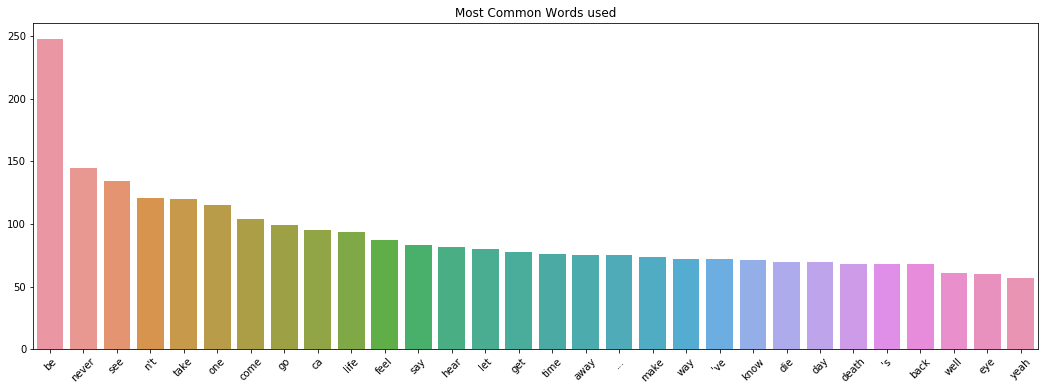

In [8]:
def get_word_frequency(df, lyric_field):
    def cleanup_text(docs, logging=False):
        texts = []
        counter = 1
        for doc in docs:
            if counter % 1000 == 0 and logging:
                print("Processed %d out of %d documents." % (counter, len(docs)))
            counter += 1
            doc = nlp(doc, disable=['parser', 'ner'])
            tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
            tokens = [tok for tok in tokens if tok not in punctuations]
            tokens = ' '.join(tokens)
            texts.append(tokens)
        return pd.Series(texts)

    df_text = [text for text in df[lyric_field]]
    df_text_clean = cleanup_text(df_text)
    df_text_clean = ' '.join(df_text_clean).split()
    df_text_clean_counts = Counter(df_text_clean)
    df_common_words = [word[0] for word in df_text_clean_counts.most_common(31)]
    df_common_counts = [word[1] for word in df_text_clean_counts.most_common(31)]
    df_common_words.pop(0)
    df_common_counts.pop(0)

    fig = plt.figure(figsize=(18,6))
    sns.barplot(x=df_common_words, y=df_common_counts)
    plt.title(f'Most Common Words used')
    plt.xticks(rotation=45)
    plt.show()
    
    fig.savefig(f'word_frequency.png', format='png', dpi=500)


get_word_frequency(df, 'song_lyric')    

In [9]:
def show_wordcloud(text, graph_title, stoplist=stoplist):
    wordcloud = \
        WordCloud(stopwords=stoplist,
                  background_color="white").generate(text)

    fig = plt.figure(figsize=(25,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud', fontsize=20)
    plt.title(f'Word Cloud for {graph_title}', fontsize=20)
    plt.axis("off")
    plt.show()
    fig.savefig(f'word_cloud.png', format='png', dpi=500)
    
def get_wordcloud(df, graph_title, lyric_field):
    text = " ".join(review for review in df[lyric_field])
    show_wordcloud(text, graph_title)     

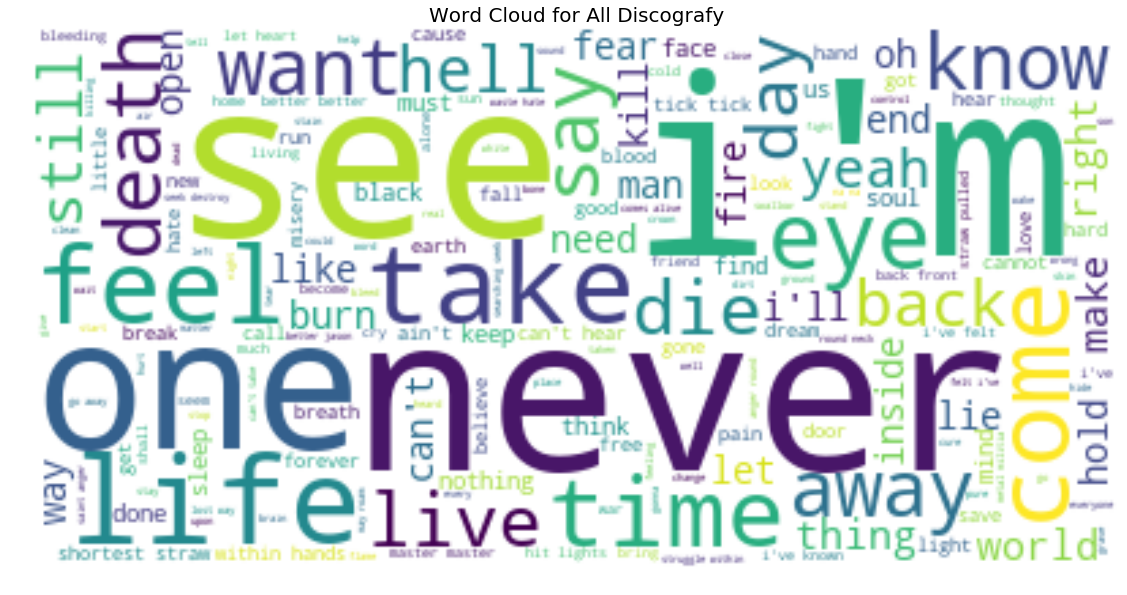

In [10]:
get_wordcloud(df, 'All Discografy', 'song_lyric')

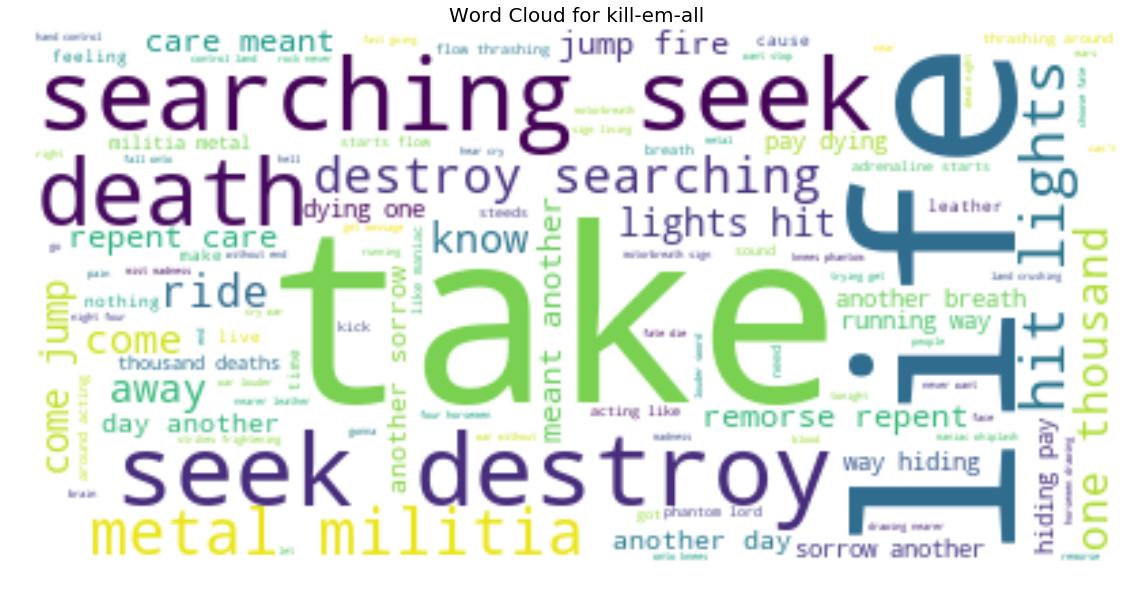

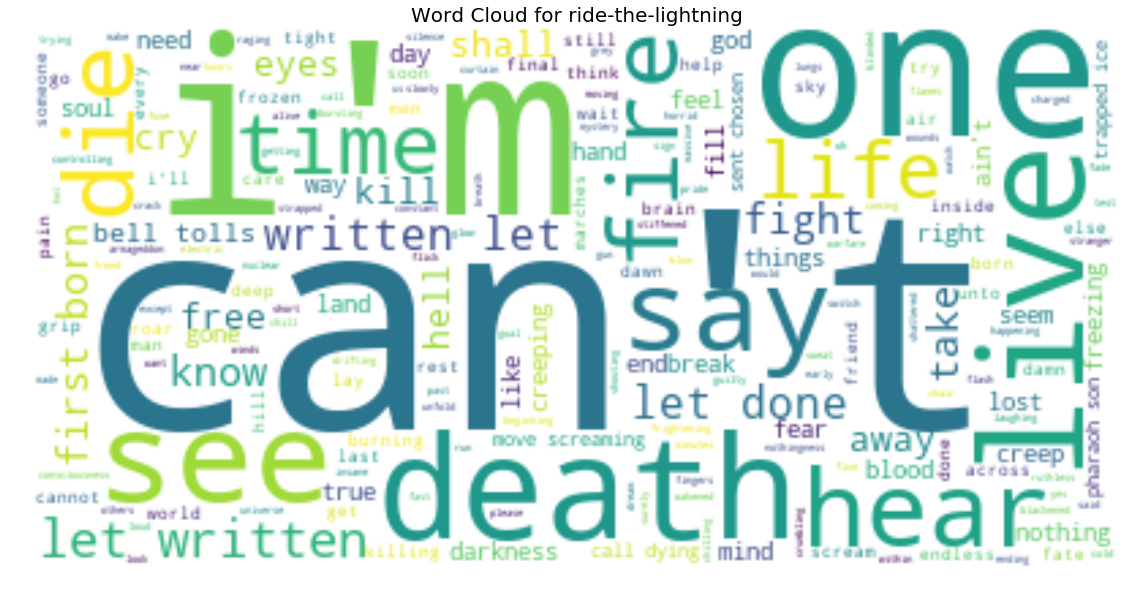

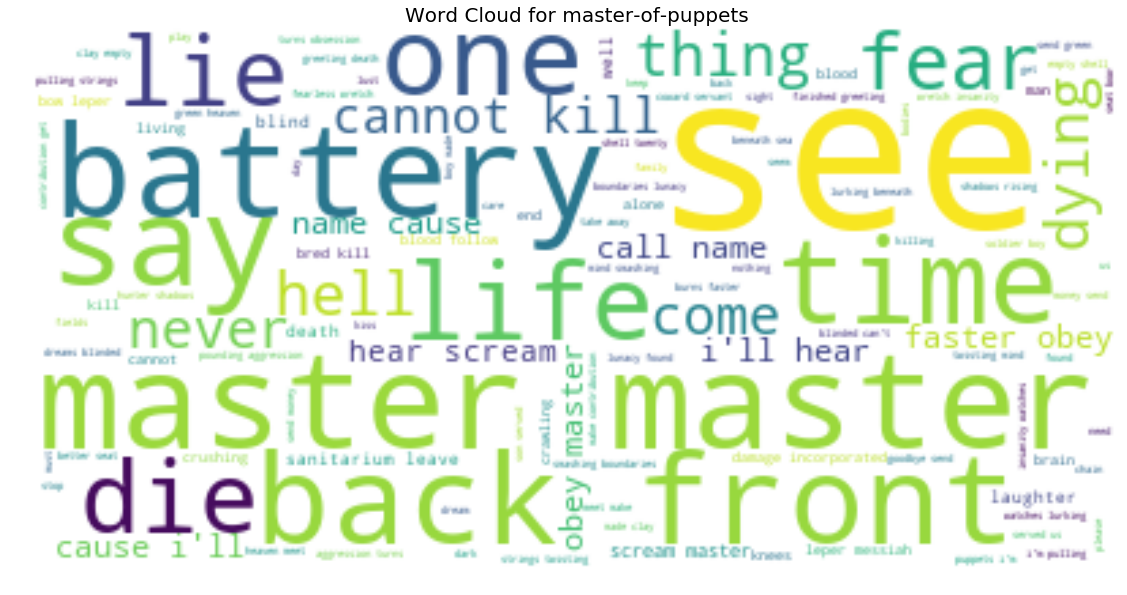

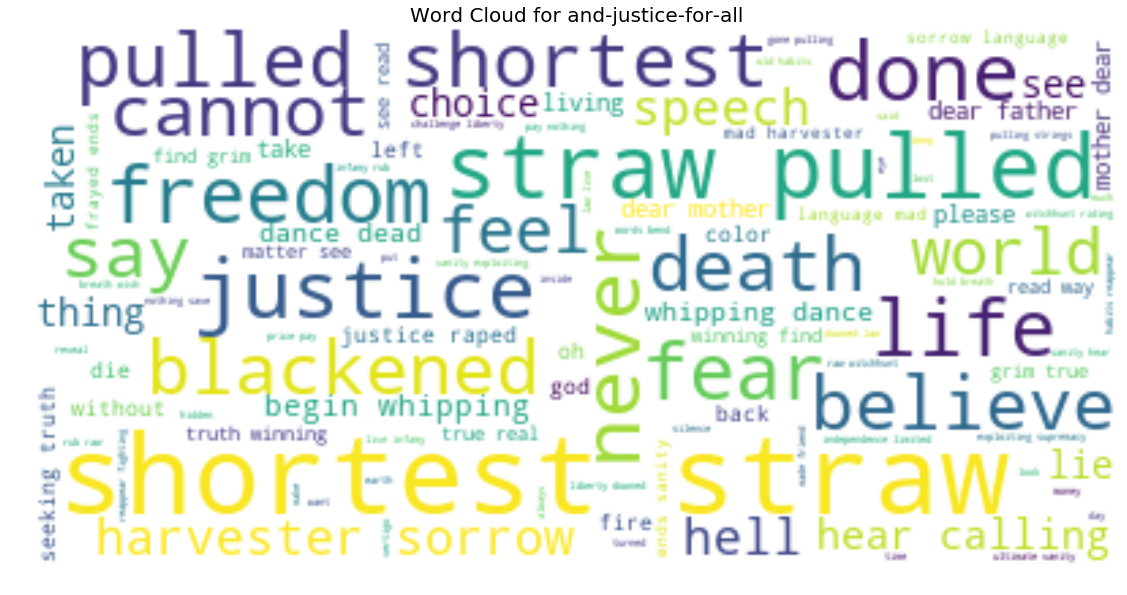

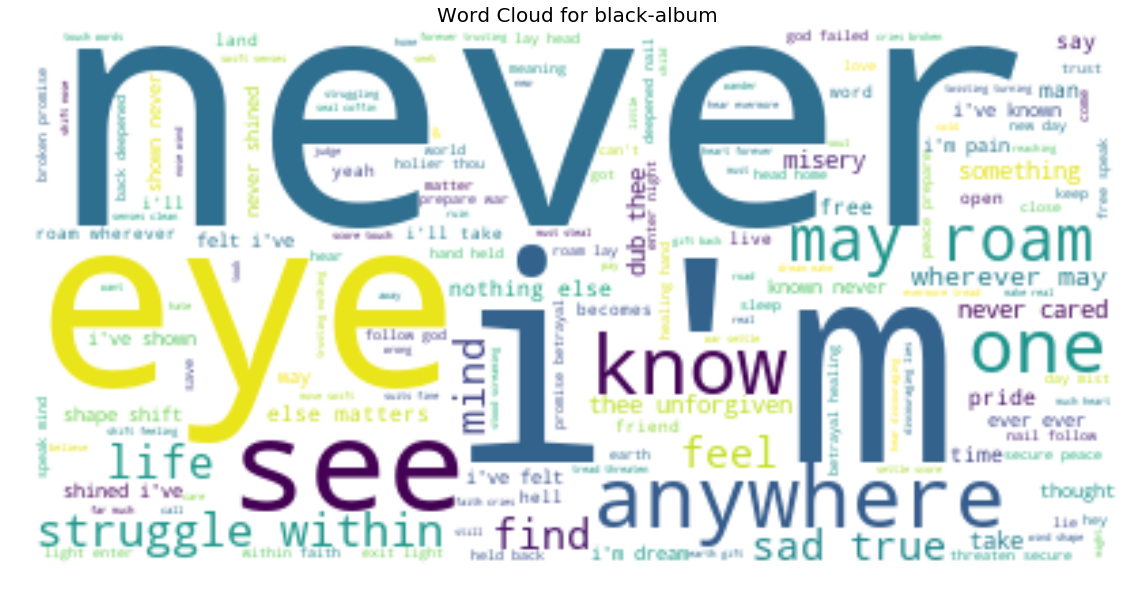

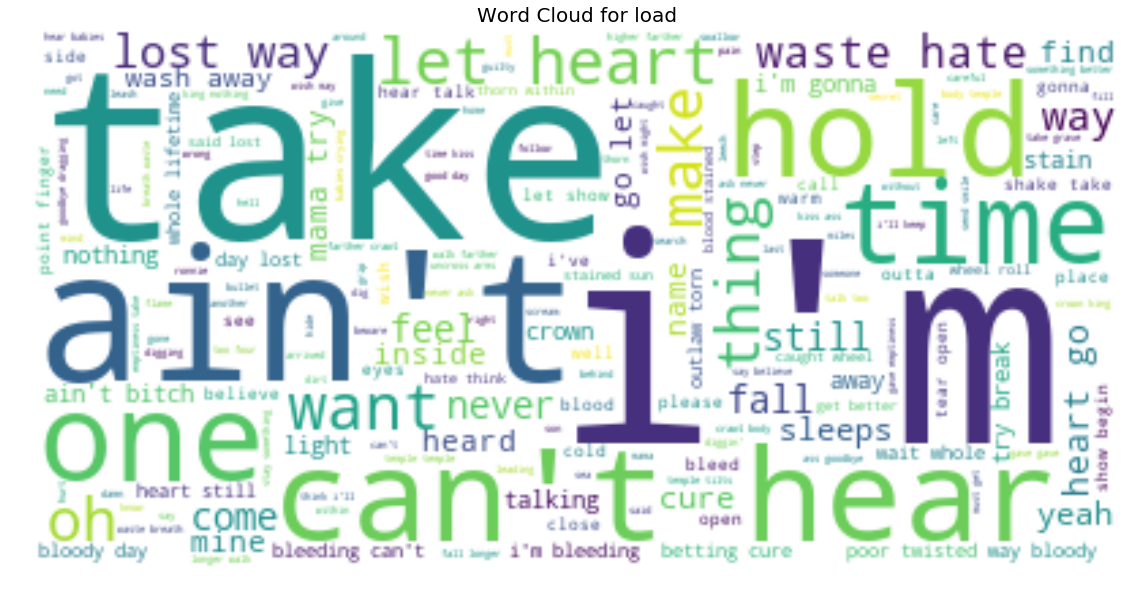

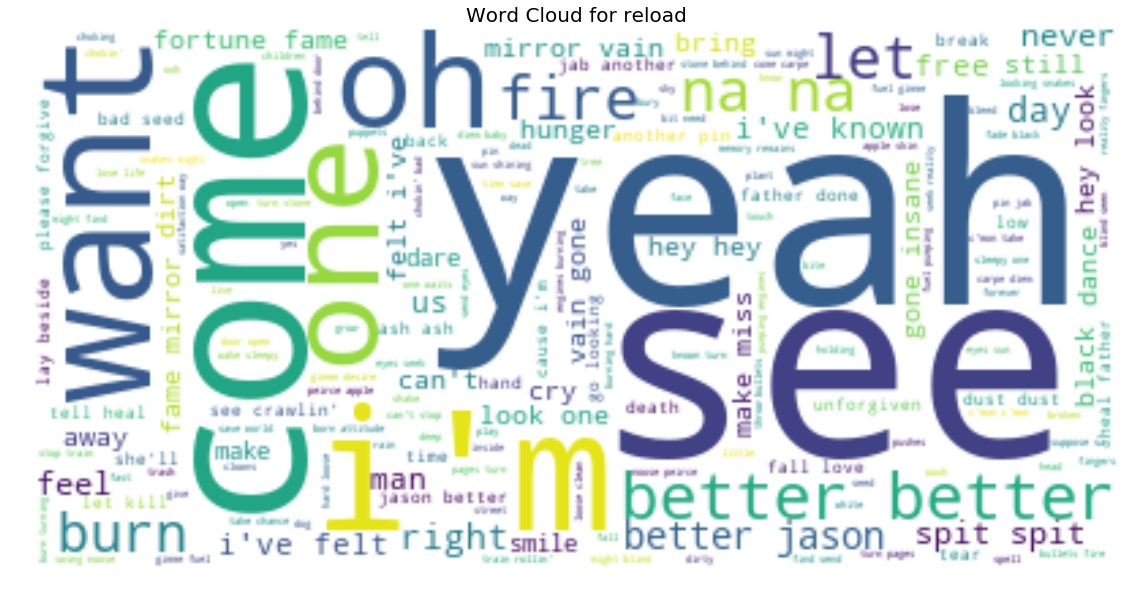

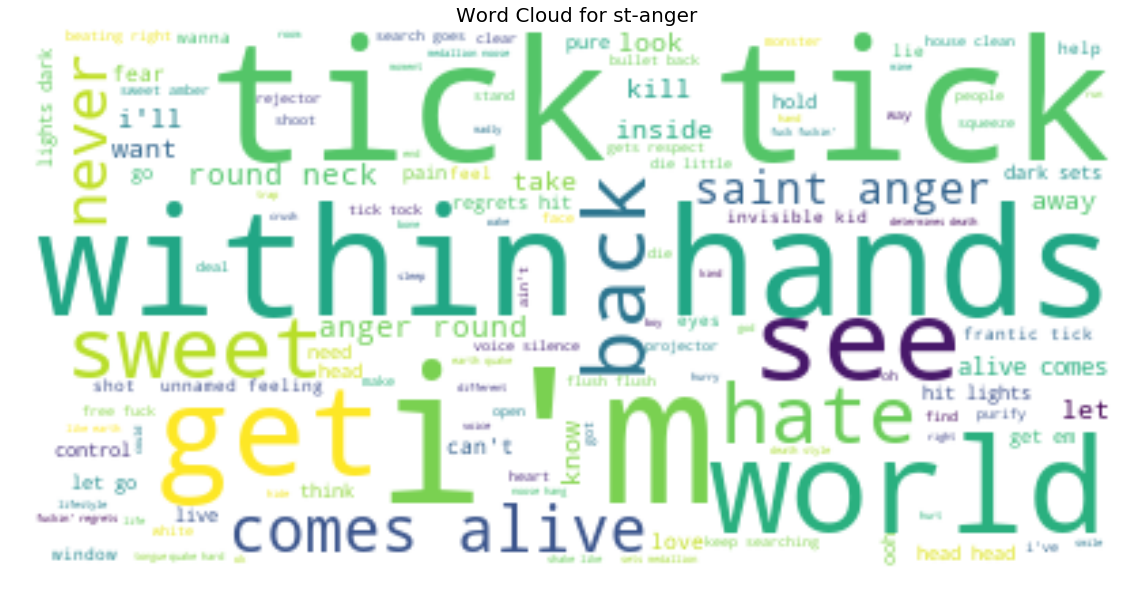

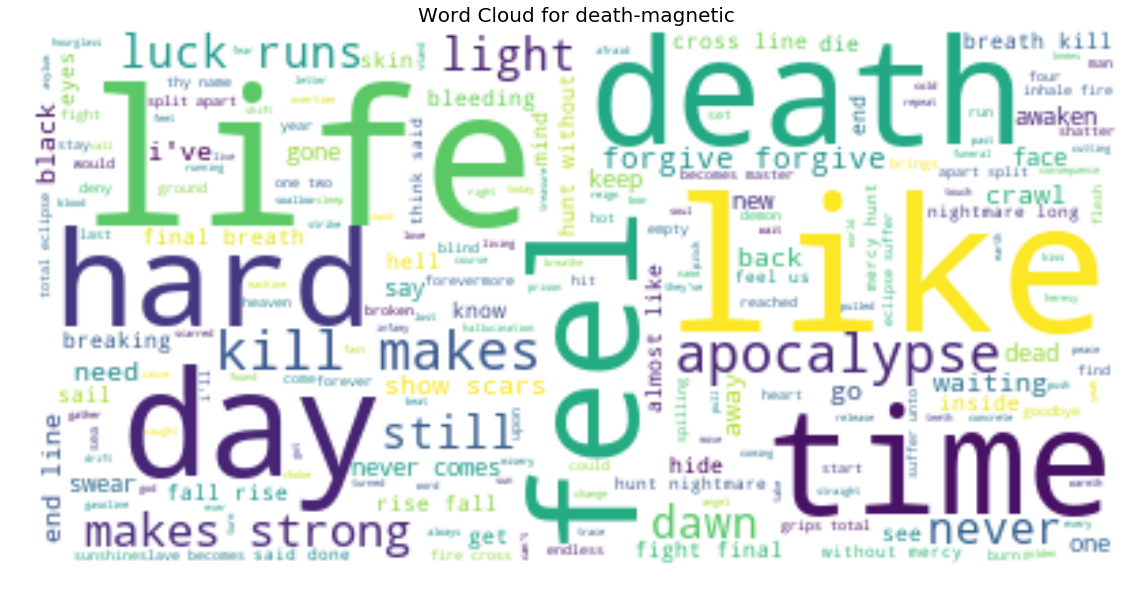

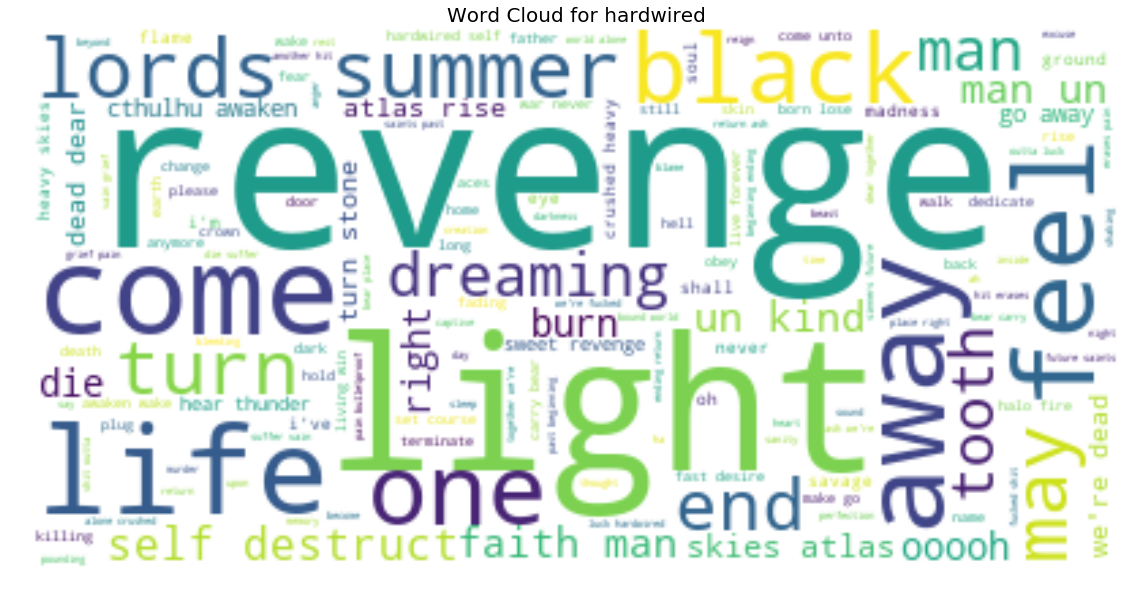

In [11]:
for album in df.album.unique():
    get_wordcloud(df[df['album'] == album], album, 'song_lyric')

### Lexical Diversity

According to [Johansson](https://journals.lub.lu.se/LWPL/article/view/2273) (2009) Lexical diversity is a measure of how *many different words that are used in a
text*. The practical use of the Lexical Diversity it's given by [McCarthy and Jarvis](https://link.springer.com/article/10.3758%2FBRM.42.2.381) (2010) they said that LD is *the range of different words used in a text, with a greater range indicating a higher diversity*.

In [12]:
def get_lexical_diversity(df, lyric_field, graph_title):
    # Word stats
    full_text_count = pd.DataFrame(Counter(" ".join(df[lyric_field]).split()), index=[0])
    full_text_count = full_text_count.T
    full_text_count = full_text_count.reset_index()
    full_text_count.columns = ['word', 'qty']

    # Distinct words to include in numerator
    distinct_words = set()
    df[lyric_field].str.lower().str.split().apply(distinct_words.update)
    total_distinct_words = len(distinct_words)

    # All words to include in denominator
    total_words = full_text_count['qty'].sum()
    lexical_diversity = round((total_distinct_words / total_words),2)
    print(f'Lexical Diversity for {graph_title}: {lexical_diversity}')
    
    
get_lexical_diversity(df, 'song_lyric', 'Discografy')    

Lexical Diversity for Discografy: 0.22


In [13]:
for album in df.album.unique():
    get_lexical_diversity(df[df['album'] == album], 'song_lyric', album)

Lexical Diversity for kill-em-all: 0.43
Lexical Diversity for ride-the-lightning: 0.58
Lexical Diversity for master-of-puppets: 0.46
Lexical Diversity for and-justice-for-all: 0.47
Lexical Diversity for black-album: 0.36
Lexical Diversity for load: 0.3
Lexical Diversity for reload: 0.31
Lexical Diversity for st-anger: 0.36
Lexical Diversity for death-magnetic: 0.51
Lexical Diversity for hardwired: 0.41


### Word N-Grams

According to Wikipedia, [n-gram is a contiguous sequence of n items from a given sample of text or speech. The items can be phonemes, syllables, letters, words or base pairs according to the application](https://en.wikipedia.org/wiki/N-gram). 

In other others, n-grams it's sequences that contain _n_ words that can be used to model the probability of some sequence appears in a corpus, in our case, the n-gram(s) we can examine the most frequent combination of _n_ words in their literary dictionary.

For a matter of simplicity will focus on combinations of Bigrams `n=2` e Trigrams `n=3`.

In [14]:
from IPython.display import display

def get_word_ngrams_list(df, lyric_field, df_title, word_ngram):

    def get_top_word_n_bigram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(word_ngram, word_ngram)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]


    common_words = get_top_word_n_bigram(df[lyric_field], 20)
    df3 = pd.DataFrame(common_words, columns = ['ngram' , 'qty'])
    print(f'Top 20 WordNGrams={word_ngram} for {df_title}')
    display(df3)

In [15]:
get_word_ngrams_list(df, 'song_lyric', 'Discografy', 2)

Top 20 WordNGrams=2 for Discografy


ngram  qty
0    shortest straw   22
1         tick tick   21
2          can hear   20
3      within hands   20
4        hit lights   15
5     master master   15
6          ve known   15
7         let heart   15
8     better better   15
9        back front   14
10          ve felt   14
11            we re   13
12     straw pulled   13
13  struggle within   13
14          felt ve   13
15         lost way   13
16            na na   13
17      comes alive   13
18   searching seek   12
19     seek destroy   12

In [16]:
for album in df.album.unique():
    get_word_ngrams_list(df[df['album'] == album], 'song_lyric', album, 2)

Top 20 WordNGrams=2 for kill-em-all


ngram  qty
0      searching seek   12
1        seek destroy   12
2       metal militia   10
3          hit lights    9
4   destroy searching    9
5        one thousand    7
6          lights hit    6
7           come jump    6
8           jump fire    6
9      remorse repent    6
10        repent care    6
11         care meant    6
12      meant another    6
13        another day    6
14        day another    6
15      another death    6
16      death another    6
17     another sorrow    6
18     sorrow another    6
19     another breath    6

Top 20 WordNGrams=2 for ride-the-lightning


ngram  qty
0      let written    6
1      written let    6
2         let done    6
3       first born    5
4       bell tolls    4
5     freezing can    3
6         can move    3
7   move screaming    3
8    screaming can    3
9         can hear    3
10       hear call    3
11      call dying    3
12      dying live    3
13        live cry    3
14     cry trapped    3
15     trapped ice    3
16       life live    3
17        live way    3
18       done sent    3
19     sent chosen    3

Top 20 WordNGrams=2 for master-of-puppets


ngram  qty
0         master master   15
1            back front   14
2           cannot kill    6
3           faster obey    6
4           obey master    6
5             call name    6
6            name cause    6
7              cause ll    6
8               ll hear    6
9           hear scream    6
10        scream master    6
11     sanitarium leave    5
12              can see    4
13            bred kill    4
14           front back    4
15            bow leper    4
16        leper messiah    4
17  damage incorporated    4
18  smashing boundaries    3
19    boundaries lunacy    3

Top 20 WordNGrams=2 for and-justice-for-all


ngram  qty
0     shortest straw   22
1       straw pulled   13
2    pulled shortest   10
3        can believe    9
4   harvester sorrow    7
5       hear calling    7
6     begin whipping    6
7     whipping dance    6
8         dance dead    6
9     straw shortest    6
10       dear mother    5
11       mother dear    5
12       dear father    5
13     blackened end    4
14            you ll    4
15     justice raped    4
16     seeking truth    4
17     truth winning    4
18      winning find    4
19         find grim    4

Top 20 WordNGrams=2 for black-album


ngram  qty
0          may roam   12
1   struggle within   12
2          sad true    9
3      wherever may    9
4          dub thee    8
5   thee unforgiven    8
6       never cared    8
7      nothing else    7
8      else matters    7
9           ll take    6
10          ve felt    6
11          felt ve    6
12         ve known    6
13      known never    6
14     never shined    6
15        shined ve    6
16         ve shown    6
17      shown never    6
18       never free    6
19       free never    6

Top 20 WordNGrams=2 for load


ngram  qty
0       can hear   17
1      let heart   15
2       lost way   13
3     waste hate   12
4       hear you   11
5       heart go    9
6       mama try    7
7         go let    7
8      wash away    7
9      ain bitch    6
10   you talking    6
11    talking me    6
12        me can    6
13   where crown    6
14     try break    6
15  bleeding can    6
16  betting cure    6
17  poor twisted    6
18   heart still    6
19    way bloody    6

Top 20 WordNGrams=2 for reload


ngram  qty
0   better better   15
1           na na   13
2    better jason   11
3       spit spit    9
4         ve felt    8
5        ve known    8
6    fortune fame    7
7     fame mirror    7
8     mirror vain    7
9       vain gone    7
10    gone insane    7
11        felt ve    7
12        hey hey    7
13      make miss    7
14       miss you    7
15       look one    7
16       hey look    7
17   jason better    6
18    see crawlin    6
19       bad seed    6

Top 20 WordNGrams=2 for st-anger


ngram  qty
0      tick tick   21
1   within hands   20
2    comes alive   13
3    saint anger   11
4    anger round   11
5     round neck   11
6    alive comes    8
7    regrets hit    6
8     hit lights    6
9    lights dark    6
10     dark sets    6
11        let go    6
12      think am    6
13     head head    6
14      head get    6
15        get em    6
16     sweet you    6
17     you sweet    6
18     sweet get    6
19  frantic tick    5

Top 20 WordNGrams=2 for death-magnetic


ngram  qty
0        kill makes    8
1      makes strong    8
2         luck runs    7
3   forgive forgive    7
4          end line    6
5        show scars    6
6       never comes    5
7       almost like    4
8         rise fall    4
9         fall rise    4
10        rise kill    4
11       dawn death    4
12      death fight    4
13      fight final    4
14     final breath    4
15      breath kill    4
16       cross line    4
17       still life    4
18     hunt without    4
19    without mercy    4

Top 20 WordNGrams=2 for hardwired


ngram  qty
0             we re   10
1      lords summer    9
2     self destruct    7
3         faith man    7
4            man un    7
5           un kind    7
6       skies atlas    6
7        atlas rise    6
8           re dead    6
9         dead dear    6
10       turn stone    6
11   cthulhu awaken    6
12          go away    6
13    sweet revenge    6
14  revenge revenge    6
15     hear thunder    6
16    crushed heavy    5
17      heavy skies    5
18   hardwired self    4
19       carry bear    4

In [17]:
for album in df.album.unique():
    get_word_ngrams_list(df[df['album'] == album], 'song_lyric', album, 3)

Top 20 WordNGrams=3 for kill-em-all


ngram  qty
0   searching seek destroy   12
1   seek destroy searching    9
2   destroy searching seek    9
3           hit lights hit    6
4        lights hit lights    6
5           come jump fire    6
6      remorse repent care    6
7        repent care meant    6
8       care meant another    6
9        meant another day    6
10     another day another    6
11       day another death    6
12   another death another    6
13    death another sorrow    6
14  another sorrow another    6
15   sorrow another breath    6
16      running way hiding    6
17          way hiding pay    6
18        hiding pay dying    6
19           pay dying one    6

Top 20 WordNGrams=3 for ride-the-lightning


ngram  qty
0      let written let    6
1     written let done    6
2    freezing can move    3
3   can move screaming    3
4   move screaming can    3
5   screaming can hear    3
6        can hear call    3
7      hear call dying    3
8      call dying live    3
9       dying live cry    3
10    live cry trapped    3
11     cry trapped ice    3
12       life live way    3
13       let done sent    3
14    done sent chosen    3
15     sent chosen one    3
16      chosen one let    3
17     one let written    3
18       let done kill    3
19     done kill first    3

Top 20 WordNGrams=3 for master-of-puppets


ngram  qty
0            faster obey master    6
1               call name cause    6
2                 name cause ll    6
3                 cause ll hear    6
4                ll hear scream    6
5            hear scream master    6
6          scream master master    6
7          master master master    5
8               back front back    4
9              front back front    4
10            bow leper messiah    4
11   smashing boundaries lunacy    3
12      boundaries lunacy found    3
13          lunacy found cannot    3
14            found cannot stop    3
15          cannot stop battery    3
16        stop battery pounding    3
17  battery pounding aggression    3
18    pounding aggression turns    3
19   aggression turns obsession    3

Top 20 WordNGrams=3 for and-justice-for-all


ngram  qty
0     shortest straw pulled   13
1     pulled shortest straw   10
2     straw pulled shortest    8
3      begin whipping dance    6
4       whipping dance dead    6
5   shortest straw shortest    6
6      straw shortest straw    6
7          dear mother dear    5
8        mother dear father    5
9     seeking truth winning    4
10       truth winning find    4
11        winning find grim    4
12           find grim true    4
13           grim true real    4
14         doesn matter see    4
15          matter see read    4
16             see read way    4
17              read way it    4
18              way it done    4
19              it done say    4

Top 20 WordNGrams=3 for black-album


ngram  qty
0    dub thee unforgiven    8
1      wherever may roam    8
2   nothing else matters    7
3             ve felt ve    6
4          felt ve known    6
5         ve known never    6
6     known never shined    6
7        never shined ve    6
8        shined ve shown    6
9         ve shown never    6
10      never free never    6
11         free never me    6
12          never me dub    6
13           me dub thee    6
14     roam wherever may    5
15      exit light enter    4
16     light enter night    4
17          ll take time    4
18    take time anywhere    4
19    time anywhere free    4

Top 20 WordNGrams=3 for load


ngram  qty
0          can hear you   11
1          let heart go    9
2          heart go let    7
3      hear you talking    6
4        you talking me    6
5        talking me can    6
6           me can hear    6
7       let heart still    6
8       lost way bloody    6
9        way bloody day    6
10      bloody day lost    6
11         day lost way    6
12  wait whole lifetime    6
13        can hear talk    5
14        talk can hear    5
15       let show begin    5
16       mama try break    5
17    caught wheel roll    5
18        said lost way    5
19    blood stained sun    5

Top 20 WordNGrams=3 for reload


ngram  qty
0               na na na   11
1    better better jason   11
2    fortune fame mirror    7
3       fame mirror vain    7
4       mirror vain gone    7
5       vain gone insane    7
6             ve felt ve    7
7          felt ve known    7
8          make miss you    7
9    better jason better    6
10   jason better better    6
11        spit spit spit    6
12      tell heal father    6
13      heal father done    6
14       jab another pin    6
15     go looking snakes    5
16  looking snakes might    5
17     snakes might find    5
18         send eyes sun    5
19        eyes sun might    5

Top 20 WordNGrams=3 for st-anger


ngram  qty
0       tick tick tick   16
1    saint anger round   11
2     anger round neck   11
3    comes alive comes    8
4    alive comes alive    7
5   regrets hit lights    6
6      hit lights dark    6
7     lights dark sets    6
8        head head get    6
9          head get em    6
10     sweet you sweet    6
11       you sweet get    6
12   frantic tick tick    5
13      tick tick tock    4
14  never gets respect    4
15    round neck flush    4
16    neck flush flush    4
17      think am think    4
18         am think am    4
19    hate kill within    4

Top 20 WordNGrams=3 for death-magnetic


ngram  qty
0         kill makes strong    8
1   forgive forgive forgive    6
2            rise fall rise    4
3            fall rise kill    4
4           rise kill makes    4
5          dawn death fight    4
6         death fight final    4
7        fight final breath    4
8         final breath kill    4
9         breath kill makes    4
10       hunt without mercy    4
11       without mercy hunt    4
12     mercy hunt nightmare    4
13      hunt nightmare long    4
14             now go think    4
15            go think said    4
16          think said done    4
17         reached end line    3
18     slave becomes master    3
19             end line end    3

Top 20 WordNGrams=3 for hardwired


ngram  qty
0              faith man un    7
1               man un kind    7
2          skies atlas rise    6
3                we re dead    6
4              re dead dear    6
5       crushed heavy skies    5
6   hardwired self destruct    4
7       cthulhu awaken wake    4
8              make go away    4
9              we re fucked    3
10           re fucked shit    3
11        fucked shit outta    3
12          shit outta luck    3
13     outta luck hardwired    3
14      luck hardwired self    3
15       self destruct self    3
16   destruct self destruct    3
17          bear carry bear    3
18         carry bear place    3
19         bear place right    3

In [18]:
for album in df.album.unique():
    get_word_ngrams_list(df[df['album'] == album], 'song_lyric', album, 4)

Top 20 WordNGrams=4 for kill-em-all


ngram  qty
0   searching seek destroy searching    9
1        seek destroy searching seek    9
2     destroy searching seek destroy    9
3              hit lights hit lights    6
4          remorse repent care meant    6
5          repent care meant another    6
6             care meant another day    6
7          meant another day another    6
8          another day another death    6
9          day another death another    6
10      another death another sorrow    6
11      death another sorrow another    6
12     another sorrow another breath    6
13            running way hiding pay    6
14              way hiding pay dying    6
15              hiding pay dying one    6
16            pay dying one thousand    6
17         dying one thousand deaths    6
18       metal militia metal militia    6
19  adrenaline starts flow thrashing    4

Top 20 WordNGrams=4 for ride-the-lightning


ngram  qty
0          let written let done    6
1   freezing can move screaming    3
2        can move screaming can    3
3       move screaming can hear    3
4       screaming can hear call    3
5           can hear call dying    3
6          hear call dying live    3
7           call dying live cry    3
8        dying live cry trapped    3
9          live cry trapped ice    3
10        written let done sent    3
11         let done sent chosen    3
12         done sent chosen one    3
13          sent chosen one let    3
14       chosen one let written    3
15          one let written let    3
16        written let done kill    3
17          let done kill first    3
18         done kill first born    3
19      kill first born pharaoh    3

Top 20 WordNGrams=4 for master-of-puppets


ngram  qty
0                    call name cause ll    6
1                    name cause ll hear    6
2                  cause ll hear scream    6
3                 ll hear scream master    6
4             hear scream master master    6
5                 back front back front    4
6      smashing boundaries lunacy found    3
7        boundaries lunacy found cannot    3
8              lunacy found cannot stop    3
9             found cannot stop battery    3
10         cannot stop battery pounding    3
11     stop battery pounding aggression    3
12    battery pounding aggression turns    3
13  pounding aggression turns obsession    3
14    aggression turns obsession cannot    3
15          turns obsession cannot kill    3
16        obsession cannot kill battery    3
17           cannot kill battery cannot    3
18             kill battery cannot kill    3
19           battery cannot kill family    3

Top 20 WordNGrams=4 for and-justice-for-all


ngram  qty
0   shortest straw pulled shortest    8
1      straw pulled shortest straw    8
2     pulled shortest straw pulled    7
3        begin whipping dance dead    6
4    shortest straw shortest straw    6
5      straw shortest straw pulled    6
6          dear mother dear father    5
7       seeking truth winning find    4
8          truth winning find grim    4
9           winning find grim true    4
10             find grim true real    4
11           doesn matter see read    4
12             matter see read way    4
13                 see read way it    4
14                read way it done    4
15                 way it done say    4
16   harvester sorrow language mad    4
17   sorrow language mad harvester    4
18   language mad harvester sorrow    4
19         frayed ends sanity hear    4

Top 20 WordNGrams=4 for black-album


ngram  qty
0             ve felt ve known    6
1          felt ve known never    6
2        ve known never shined    6
3        known never shined ve    6
4        never shined ve shown    6
5        shined ve shown never    6
6          never free never me    6
7            free never me dub    6
8            never me dub thee    6
9       me dub thee unforgiven    6
10      roam wherever may roam    5
11      exit light enter night    4
12       ll take time anywhere    4
13     take time anywhere free    4
14    time anywhere free speak    4
15    anywhere free speak mind    4
16  anywhere anywhere may roam    4
17       anywhere may roam lay    4
18           may roam lay head    4
19          roam lay head home    4

Top 20 WordNGrams=4 for load


ngram  qty
0             let heart go let    7
1         can hear you talking    6
2          hear you talking me    6
3           you talking me can    6
4          talking me can hear    6
5              me can hear you    6
6          lost way bloody day    6
7          way bloody day lost    6
8          bloody day lost way    6
9            talk can hear you    5
10        said lost way bloody    5
11       time kiss ass goodbye    4
12           ain fall ain call    4
13           fall ain call ain    4
14          ain call ain bitch    4
15  higher farther fall longer    4
16    farther fall longer walk    4
17    fall longer walk farther    4
18   longer walk farther crawl    4
19     walk farther crawl body    4

Top 20 WordNGrams=4 for reload


ngram  qty
0                  na na na na    9
1     fortune fame mirror vain    7
2        fame mirror vain gone    7
3      mirror vain gone insane    7
4             ve felt ve known    7
5   better better jason better    6
6   better jason better better    6
7        tell heal father done    6
8    jason better better jason    5
9      go looking snakes might    5
10   looking snakes might find    5
11         send eyes sun might    5
12        eyes sun might blind    5
13       gimme fuel gimme fire    4
14       fuel gimme fire gimme    4
15     gimme fire gimme desire    4
16            one day see dare    4
17           day see dare come    4
18          see dare come yeah    4
19          dare come yeah mon    4

Top 20 WordNGrams=4 for st-anger


ngram  qty
0       tick tick tick tick   12
1    saint anger round neck   11
2   comes alive comes alive    7
3   regrets hit lights dark    6
4      hit lights dark sets    6
5          head head get em    6
6       sweet you sweet get    6
7    frantic tick tick tick    4
8       tick tick tick tock    4
9    anger round neck flush    4
10   round neck flush flush    4
11        think am think am    4
12  alive comes alive comes    4
13   hate kill within hands    4
14  fuck regrets hit lights    3
15    lights dark sets need    3
16     dark sets need voice    3
17      sets need voice let    3
18       need voice let let    3
19         voice let let go    3

Top 20 WordNGrams=4 for death-magnetic


ngram  qty
0   forgive forgive forgive forgive    5
1               rise fall rise kill    4
2              fall rise kill makes    4
3            rise kill makes strong    4
4            dawn death fight final    4
5          death fight final breath    4
6           fight final breath kill    4
7           final breath kill makes    4
8          breath kill makes strong    4
9           hunt without mercy hunt    4
10     without mercy hunt nightmare    4
11        mercy hunt nightmare long    4
12                now go think said    4
13               go think said done    4
14                end line end line    3
15           kill makes strong rise    3
16           makes strong rise fall    3
17            strong rise fall rise    3
18           kill makes strong dawn    3
19          makes strong dawn death    3

Top 20 WordNGrams=4 for hardwired


ngram  qty
0              faith man un kind    7
1                we re dead dear    6
2              we re fucked shit    3
3           re fucked shit outta    3
4         fucked shit outta luck    3
5      shit outta luck hardwired    3
6      outta luck hardwired self    3
7   luck hardwired self destruct    3
8    self destruct self destruct    3
9          bear carry bear place    3
10        carry bear place right    3
11        bear place right right    3
12         place right right die    3
13        right right die suffer    3
14         right die suffer vain    3
15         die suffer vain grief    3
16        suffer vain grief pain    3
17           vain grief pain die    3
18           grief pain die hold    3
19           pain die hold skies    3

### LDA

In [19]:
def get_topics(df, lyric_field, n_components, number_words):
    
    data = df[lyric_field].values.tolist()
    vectorizer = \
        CountVectorizer(
            analyzer='word',
            min_df=10,
            stop_words='english',
            lowercase=True,
            token_pattern='[a-zA-Z0-9]{3,}',
    )

    data_vectorized = vectorizer.fit_transform(data)

    # Materialize the sparse data
    data_dense = data_vectorized.todense()

    # Compute Sparsicity = Percentage of Non-Zero cells
    print(f'Sparsicity: {((data_dense > 0).sum()/data_dense.size)*100}')

    # Build LDA Model
    lda_model = \
        LatentDirichletAllocation(
            n_components=n_components,
            max_iter=30,
            learning_method='online',
            random_state=42,
            batch_size=10,
            evaluate_every = -1,
            n_jobs = -1,
        )
    
    
    lda_output = \
        lda_model.fit_transform(data_vectorized)

    # Helper function
    def print_topics(model, count_vectorizer, n_top_words):
        words = count_vectorizer.get_feature_names()
        for topic_idx, topic in enumerate(model.components_):
            print("\nTopic #%d:" % topic_idx)
            print(" ".join([words[i]
                            for i in topic.argsort()[:-n_top_words - 1:-1]]))

    # Print the topics found by the LDA model
    print("Topics found via LDA:")
    lda_model.fit(data_vectorized)
    print_topics(lda_model, vectorizer, number_words)
    return lda_model, data_vectorized, data, lda_output, vectorizer

In [20]:
lda_model_metallica, data_vectorized_metallica, \
data_metallica, lda_output_metallica, vectorizer_metallica = \
    get_topics(df, 'song_lyric', n_components=7, number_words=10)

Sparsicity: 16.373626373626372
Topics found via LDA:

Topic #0:
yeah world comes head look clean free little time earth

Topic #1:
hear light fall hand eyes save hell fear say open

Topic #2:
death kill die think hell say day blood breath end

Topic #3:
heart life live hold living free open tell left away

Topic #4:
away way better time know life want inside feel pain

Topic #5:
black sun burn hard dark soul dead eyes face man

Topic #6:
let come man like make gone day feel eyes time


# Topic Per Document  

One important thing that we can do it's to generate a topic score for each document and based on that see which topic it's more dominant in a certain document. This is important because language can have several overlaps and combinations in words and ambiguity.  

One thing that can be made it's to define some score to assess the "purity" of some document inside a particular topic.  

In [21]:
def get_topic_per_document(lda_model, data_vectorized, data, lda_output):
    # Create Document - Topic Matrix
    lda_output = lda_model.transform(data_vectorized)

    # column names
    topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

    # index names
    docnames = ["Doc" + str(i) for i in range(len(data))]

    # Make the pandas dataframe
    df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

    # Get dominant topic for each document
    dominant_topic = np.argmax(df_document_topic.values, axis=1)
    df_document_topic['dominant_topic'] = dominant_topic

    # Styling
    def color_green(val):
        color = 'green' if val > .1 else 'black'
        return 'color: {col}'.format(col=color)

    def make_bold(val):
        weight = 700 if val > .1 else 400
        return 'font-weight: {weight}'.format(weight=weight)

    # Apply Style
    df_document_topics_styled = df_document_topic.style.applymap(color_green).applymap(make_bold)
    
    return df_document_topics_styled, df_document_topic

In [22]:
df_topic_per_document_metallica_styled, df_topic_per_document_metallica = \
    get_topic_per_document(lda_model_metallica,
                           data_vectorized_metallica,
                           data_metallica,
                           lda_output_metallica)

df_topic_per_document_metallica_styled

In [23]:
df_topic_per_document_metallica.groupby(['dominant_topic']).size()

dominant_topic
0    10
1    12
2    17
3     8
4    36
5     5
6    16
dtype: int64

In [24]:
df_topic_per_document_metallica = \
    df_topic_per_document_metallica.reset_index()

In [25]:
def get_lyric_by_topic(df_doc_topics, df_lyrics, topic_number):
    topic_index_list = \
        df_doc_topics[df_doc_topics['dominant_topic'] == topic_number].index
    print(f'Songs for Topic: {topic_number}')
    display(df_lyrics.iloc[topic_index_list])

In [26]:
get_lyric_by_topic(df_topic_per_document_metallica, df, 0)

Songs for Topic: 0


album  track_number                   song_name  \
30  and-justice-for-all             8           To Live Is To Die   
36          black-album             5         Wherever I May Roam   
42          black-album            11         My Friend Of Misery   
65               reload             8                    Bad Seed   
66               reload             9   Where The Wild Things Are   
67               reload            10             Prince Charming   
72             st-anger             2                   St. Anger   
74             st-anger             4                Dirty Window   
76             st-anger             6                    My World   
79             st-anger             9             Unnamed Feeling   

                                           song_lyric  
30  man lies murders part world pale deaths men mi...  
36  (...and road becomes bride)⟓ ...and road becom...  
42  stood screaming fearing one listening say empt...  
65  yeah yeah yeah yeah ooooohhhh yeah bad yeah co...  
66  wake sleepy one... time save world... steal dr...  
67  black cloud head that's poison ivy chokes tree...  
72  saint anger 'round neck saint anger 'round nec...  
74  see reflection window looks different differen...  
76  motherfuckers got head trying make someone els...  
79  say liked start writing down? let plug world c...

In [27]:
for topic_number in df_topic_per_document_metallica.dominant_topic.unique():
    get_lyric_by_topic(df_topic_per_document_metallica, df, topic_number)

Songs for Topic: 4


album  track_number                   song_name  \
0            kill-em-all             1              Hit The Lights   
1            kill-em-all             2           The Four Horsemen   
7            kill-em-all             9              Seek & Destroy   
10    ride-the-lightning             2          Ride The Lightning   
11    ride-the-lightning             3     For Whom The Bell Tolls   
14    ride-the-lightning             6                      Escape   
17     master-of-puppets             2           Master Of Puppets   
19     master-of-puppets             4   Welcome Home (Sanitarium)   
21     master-of-puppets             6               Leper Messiah   
25   and-justice-for-all             3         Eye Of The Beholder   
28   and-justice-for-all             6         Harvester Of Sorrow   
33           black-album             2                Sad But True   
34           black-album             3            Holier Than Thou   
39           black-album             8        Nothing Else Matters   
43           black-album            12         The Struggle Within   
44                  load             1              Ain't My Bitch   
46                  load             3        The House Jack Built   
48                  load             5                King Nothing   
50                  load             7                 Bleeding Me   
51                  load             8                        Cure   
52                  load             9             Poor Twisted Me   
55                  load            12                Thorn Within   
56                  load            13                      Ronnie   
57                  load            14             The Outlaw Torn   
62                reload             5             Better Than You   
71              st-anger             1                     Frantic   
73              st-anger             3        Some Kind Of Monster   
75              st-anger             5               Invisible Kid   
77              st-anger             7              Shoot Me Again   
78              st-anger             8                 Sweet Amber   
83        death-magnetic             2         The End Of The Line   
85        death-magnetic             4    The Day That Never Comes   
88        death-magnetic             7          The Unforgiven III   
91             hardwired             1                   Hardwired   
92             hardwired             2                Atlas  Rise!   
100            hardwired            10                Am I Savage?   

                                            song_lyric  
0    life till leather gonna kick ass tonight got m...  
1    last breath fourth winds blow better raise ear...  
7    scanning scene city tonight looking start figh...  
10   guilty charged damn it, ain't right someone el...  
11   make fight hill early day constant chill deep ...  
14   feel pain, life ain't easy know i'm best frien...  
17   end passion play crumbling away i'm source sel...  
19   welcome time stands still one leaves one moon ...  
21   spineless start sucked part circus comes town ...  
25   see see? truth offence silence confidence hear...  
28   life suffocates planting seeds hate i’ve loved...  
33   hey i'm life i'm one takes hey i'm life i'm on...  
34   more! craps rolls mouth changed brain still ge...  
39   close matter far much heart forever trusting n...  
43   reaching something got feel clutching thought ...  
44   outta way outta day mind mine one one step tim...  
46   open door walk inside close eyes find place hi...  
48   wish may wish might wish tonight satisfied? di...  
50   i'm diggin' way i'm diggin' way something i'm ...  
51   man takes another bullet keeps within must see...  
52   oh poor twisted oh poor twisted feast sympathy...  
55   forgive father sinned find guilty life feel wi...  
56   story starts quiet town small-town boy big-tim...  
57   wait whole lifetime wait whole lifetime ride d...  
62 

Songs for Topic: 3


album  track_number            song_name  \
2           kill-em-all             3          Motorbreath   
26  and-justice-for-all             4                  One   
27  and-justice-for-all             5   The Shortest Straw   
35          black-album             4       The Unforgiven   
47                 load             4      Until It Sleeps   
61               reload             4    The Unforgiven II   
70               reload            13              Fixxxer   
99            hardwired             9   Here Comes Revenge   

                                           song_lyric  
2   living dying laughing crying seen never life f...  
26  can’t remember anything can’t tell true dream ...  
27  suspicion name honesty blame put dignity shame...  
35  new blood joins earth quickly he's subdued. co...  
47  take pain mine? run stays right side tear open...  
61  lay beside tell they've done speak words wanna...  
70  dolls voodoo stuck pins one us sins lay us lin...  
99  little grave i'm grieving mend sweet revenge i...

Songs for Topic: 6


album  track_number                 song_name  \
3           kill-em-all             4          Jump In The Fire   
4           kill-em-all             6                  Whiplash   
8           kill-em-all            10             Metal Militia   
15   ride-the-lightning             7            Creeping Death   
40          black-album             9           Of Wolf And Man   
45                 load             2                     2 x 4   
54                 load            11                 Mama Said   
59               reload             2        The Memory Remains   
60               reload             3             Devil's Dance   
64               reload             7           Carpe Diem Baby   
68               reload            11           Low Man's Lyric   
82       death-magnetic             1   That Was Just Your Life   
86       death-magnetic             5        All Nightmare Long   
97            hardwired             7                 Confusion   
98            hardwired             8                 ManUNkind   
102           hardwired            12         Spit Out the Bone   

                                            song_lyric  
3    depths fiery home summons bell chime tempting ...  
4    late night systems go come see show best rest ...  
8    thunder lightning gods take revenge senseless ...  
15   slaves hebrews born serve, pharaoh heed every ...  
40   new day's mist run new day's mist come hunt th...  
45   i'm gonna make shake take i'm gonna one breaks...  
54   mama taught well told young son life's open bo...  
59   fortune fame mirror vain gone insane memory re...  
60   yeah feel feel things eyes see fire burns free...  
64   hit dirt shake tree split sky part sea strip s...  
68   eyes seek reality fingers seek veins theres do...  
82   like siren head always threatens repeat like b...  
86   one two luck. runs. out. crawl wreckage one ti...  
97   wake face day grab life walk away war never do...  
98   chaos awaiting adams return madness smiling wa...  
102  come unto feel perfection come unto dedicate c...

Songs for Topic: 1


album  track_number                   song_name  \
5            kill-em-all             7                Phantom Lord   
13    ride-the-lightning             5           Trapped Under Ice   
24   and-justice-for-all             2      ...And Justice For All   
29   and-justice-for-all             7   The Frayed Ends Of Sanity   
32           black-album             1               Enter Sandman   
37           black-album             6           Don't Tread On Me   
41           black-album            10         The God That Failed   
49                  load             6             Hero Of The Day   
80              st-anger            10                      Purify   
94             hardwired             4             Moth Into Flame   
96             hardwired             6                Halo On Fire   
101            hardwired            11                  Murder One   

                                            song_lyric  
5    sound ripping ears deafening sound metal nears...  
13   know live trough hell woken up, i'm still lock...  
24   halls justice painted green money talking powe...  
29   never hunger never prosper fallen prey failure...  
32   say prayers little one forget son include ever...  
37   liberty death proudly hail provoke rattling ta...  
41   pride took pride feel pride felt kneel word lo...  
49   mama try break window burns light way back hom...  
80   tear strip layers turpentine old paint old loo...  
94   blacked pop queen amphetamine screams crashed ...  
96   obey obey come stay sincere sincere ends tears...  
101  one crown shines sound one crown born lose one...

Songs for Topic: 2


album  track_number                      song_name  \
6           kill-em-all             8                     No Remorse   
9    ride-the-lightning             1           Fight Fire With Fire   
12   ride-the-lightning             4                  Fade To Black   
16    master-of-puppets             1                        Battery   
18    master-of-puppets             3   The Thing That Should Not Be   
20    master-of-puppets             5              Disposable Heroes   
22    master-of-puppets             8                   Damage  Inc.   
23  and-justice-for-all             1                      Blackened   
31  and-justice-for-all             9                      Dyers Eve   
53                 load            10                Wasting My Hate   
69               reload            12                       Attitude   
81             st-anger            11            All Within My Hands   
84       death-magnetic             3         Broken  Beat & Scarred   
87       death-magnetic             6                        Cyanide   
89       death-magnetic             8                 The Judas Kiss   
90       death-magnetic            10                  My Apocalypse   
95            hardwired             5                  Dream No More   

                                           song_lyric  
6   mercy thought even done need feel sorrow remor...  
9   unto others done unto hell world coming to? bl...  
12  life seems, fade away drifting every day getti...  
16  lashing action returning reaction weak ripped ...  
18  messenger fear sight dark deception kills ligh...  
20  bodies fill fields see hungry heroes end one p...  
22  dealing agony within charging hard one's gonna...  
23  blackened end winter send throwing see obscuri...  
31  dear mother dear father hell put believer dece...  
53  good day. do? send smile waste waste breath wa...  
69  suppose say i'm never satisfied suppose say cu...  
81  within hands squeeze crush within hands hold d...  
84  rise fall rise kill makes strong rise fall ris...  
87  sleep dream death angel's kiss brings final bl...  
89  world turned back days turned pitch black fear...  
90  claustrophobic crawl skin heart explosive reac...  
95  sleeps black seas waiting lies dreaming death ...

Songs for Topic: 0


album  track_number                   song_name  \
30  and-justice-for-all             8           To Live Is To Die   
36          black-album             5         Wherever I May Roam   
42          black-album            11         My Friend Of Misery   
65               reload             8                    Bad Seed   
66               reload             9   Where The Wild Things Are   
67               reload            10             Prince Charming   
72             st-anger             2                   St. Anger   
74             st-anger             4                Dirty Window   
76             st-anger             6                    My World   
79             st-anger             9             Unnamed Feeling   

                                           song_lyric  
30  man lies murders part world pale deaths men mi...  
36  (...and road becomes bride)⟓ ...and road becom...  
42  stood screaming fearing one listening say empt...  
65  yeah yeah yeah yeah ooooohhhh yeah bad yeah co...  
66  wake sleepy one... time save world... steal dr...  
67  black cloud head that's poison ivy chokes tree...  
72  saint anger 'round neck saint anger 'round nec...  
74  see reflection window looks different differen...  
76  motherfuckers got head trying make someone els...  
79  say liked start writing down? let plug world c...

Songs for Topic: 5


album  track_number             song_name  \
38   black-album             7     Through The Never   
58        reload             1                  Fuel   
63        reload             6               Slither   
93     hardwired             3   Now That We're Dead   
103    hardwired            13       Lords Of Summer   

                                            song_lyric  
38   universe much big see time space never ending ...  
58   gimme fuel gimme fire gimme desire ooh! turn s...  
63   go looking snakes might find send eyes sun mig...  
93   darkness falls may see light reaper calls may ...  
103  sight pale riders night galloping harder faste...

## Topic Distribution

In [28]:
def get_topic_distribution(df_document_topic):
    df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
    df_topic_distribution.columns = ['Topic Num', 'Num Documents']
    total_docs = df_topic_distribution['Num Documents'].sum()
    df_topic_distribution['perc_per_topic'] = np.round(((df_topic_distribution['Num Documents'] /total_docs) * 100), 2)

    return df_topic_distribution

In [29]:
get_topic_distribution(df_topic_per_document_metallica)

Topic Num  Num Documents  perc_per_topic
0          4             36           34.62
1          2             17           16.35
2          6             16           15.38
3          1             12           11.54
4          0             10            9.62
5          3              8            7.69
6          5              5            4.81

## Word Topics
Here is only a table for us to check the order of the words in the topics that permeate the literary part of these two bands.

A special highlight here is that in this dataframe is also considered the frequency and ordinality of the word within the topic. 

In [30]:
def get_word_topics(vectorizer, lda_model):

    # Show top n keywords for each topic
    def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
        keywords = np.array(vectorizer.get_feature_names())
        topic_keywords = []
        for topic_weights in lda_model.components_:
            top_keyword_locs = (-topic_weights).argsort()[:n_words]
            topic_keywords.append(keywords.take(top_keyword_locs))
        return topic_keywords

    topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=10)        

    # Topic - Keywords Dataframe
    df_topic_keywords = pd.DataFrame(topic_keywords)
    df_topic_keywords.columns = ['Word '+ str(i) for i in range(df_topic_keywords.shape[1])]
    df_topic_keywords.index = ['Topic '+ str(i) for i in range(df_topic_keywords.shape[0])]

    return df_topic_keywords

In [31]:
get_word_topics(vectorizer_metallica, lda_model_metallica)

Word 0 Word 1  Word 2 Word 3  Word 4 Word 5 Word 6  Word 7  Word 8  \
Topic 0   yeah  world   comes   head    look  clean   free  little    time   
Topic 1   hear  light    fall   hand    eyes   save   hell    fear     say   
Topic 2  death   kill     die  think    hell    say    day   blood  breath   
Topic 3  heart   life    live   hold  living   free   open    tell    left   
Topic 4   away    way  better   time    know   life   want  inside    feel   
Topic 5  black    sun    burn   hard    dark   soul   dead    eyes    face   
Topic 6    let   come     man   like    make   gone    day    feel    eyes   

        Word 9  
Topic 0  earth  
Topic 1   open  
Topic 2    end  
Topic 3   away  
Topic 4   pain  
Topic 5    man  
Topic 6   time

## Topic Plotting with word distribution

Here with the `pyLDAvis` library, we can take a look in how the topics are distributed via visual inspection. The graph presented by `pyLDAvis` it's called Intertopic Distance Map that consists in a [two-dimensional plane whose centers are determined by computing the distance between topics, and then by using multidimensional scaling to project the intertopic distances onto two dimensions](http://www.kennyshirley.com/LDAvis/#topic=1&lambda=1&term=).

With that, we're able to interpret the composition of each topic and which individual terms are most useful inside of some topic. 

A most comprehensive introduction about the LDAVis can be found in [Sievert, C., & Shirley, K. (2014). LDAvis: A method for visualizing and interpreting topics. In Proceedings of the workshop on interactive language learning, visualization, and interfaces (pp. 63-70)](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf).

In [32]:
def get_lda_plot(lda_model, data_vectorized, vectorizer):
    pyLDAvis.enable_notebook()
    panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
    return panel

In [33]:
get_lda_plot(lda_model_metallica, data_vectorized_metallica, vectorizer_metallica)

/Users/flavioclesio/Documents/github/metallica-topic-modeling/metallica-venv/lib/python3.6/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
4     -29.594002  60.112713       1        1  27.581702
6     -45.996586  11.891685       2        1  19.023399
2      20.368856  70.019325       3        1  15.676749
0      53.928768  31.704309       4        1  10.953344
3     -12.437127 -26.423267       5        1  10.418362
1       3.965971  21.797720       6        1  10.265236
5      37.524284 -16.517805       7        1   6.081208, topic_info=     Term       Freq      Total Category  logprob  loglift
29   hear  71.000000  71.000000  Default  30.0000  30.0000
38    let  71.000000  71.000000  Default  29.0000  29.0000
9    come  66.000000  66.000000  Default  28.0000  28.0000
69   yeah  57.000000  57.000000  Default  27.0000  27.0000
2   black  31.000000  31.000000  Default  26.0000  26.0000
..    ...        ...        ...      ...      ...      ...
24   gone   0.132110  34.066738   Topic7  -7.0859  -2.7525
0    away   0.132107  75.047751   Topic7  -7.0859  -3.5423
64   time   0.132061  70.997236   Topic7  -7.0863  -3.4872
15    die   0.132045  47.244854   Topic7  -7.0864  -3.0800
23   free   0.132034  37.077337   Topic7  -7.0865  -2.8377

[278 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         1  0.892765    away
0         5  0.106599    away
1         1  0.974526  better
2         7  0.969799   black
3         2  0.110062   blood
...     ...       ...     ...
68        1  0.323003   wrong
68        4  0.323003   wrong
68        5  0.323003   wrong
69        2  0.227477    yeah
69        4  0.752424    yeah

[167 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 3, 1, 4, 2, 6])

## References and useful links

- **Latent Dirichlet Allocation** - [Latent Dirichlet Allocation](https://jmlr.org/papers/volume3/blei03a/blei03a.pdf)  

- **LDAvis: A method for visualizing and interpreting topics** - [LDAvis: A method for visualizing and interpreting topics](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf)  

- **Machine Learning Plus** - [LDA in Python – How to grid search best topic models?](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/)  

- **Susan Li** - [Building a Content Based Recommender System for Hotels in Seattle](https://towardsdatascience.com/building-a-content-based-recommender-system-for-hotels-in-seattle-d724f0a32070)  

- **Susan Li** - [Automatically Generate Hotel Descriptions with LSTM](https://towardsdatascience.com/automatically-generate-hotel-descriptions-with-lstm-afa37002d4fc)  

- **Shashank Kapadia** - [End-To-End Topic Modeling in Python: Latent Dirichlet Allocation (LDA)](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)  

- **Meghana Bhange** - [Arctic Monkeys Lyrics Generator with Data Augmentation](https://towardsdatascience.com/arctic-monkeys-lyrics-generator-with-data-augmentation-b9b1f7989db0)  

- **Greg Rafferty** - [LDA on the Texts of Harry Potter](https://towardsdatascience.com/basic-nlp-on-the-texts-of-harry-potter-topic-modeling-with-latent-dirichlet-allocation-f3c00f77b0f5)  

- **Code Academy** - [Using Machine Learning to Analyze Taylor Swift's Lyrics](https://news.codecademy.com/taylor-swift-lyrics-machine-learning/)

- **Alexander Bell** - [Music Lyrics Analysis: Using Natural Language Processing to create a Lyrics-Based Music Recommender](https://medium.com/@alexwbell/music-lyrics-analysis-using-natural-language-processing-to-create-a-lyrics-based-music-recommender-43e35896a4de)

- **Trucks and Beer** - [Amazing project with Lyrics scrapper](https://github.com/johnwmillr/trucks-and-beer)

- **Anders Olson-Swanson** - [Natural Language Processing and Rap Lyrics](https://towardsdatascience.com/natural-language-processing-and-rap-lyrics-c678e60073fb)

- **Brandon Punturo** - [Drake — Using Natural Language Processing to understand his lyrics](https://towardsdatascience.com/drake-using-natural-language-processing-to-understand-his-lyrics-49e54ace3662)

- **Degenerate State** - [Heavy Metal and Natural Language Processing - Part 1](http://www.degeneratestate.org/posts/2016/Apr/20/heavy-metal-and-natural-language-processing-part-1/)

- **Degenerate State** - [Heavy Metal and Natural Language Processing - Part 2](http://www.degeneratestate.org/posts/2016/Sep/12/heavy-metal-and-natural-language-processing-part-2/)

- **Degenerate State** - [Heavy Metal and Natural Language Processing - Part 3](http://www.degeneratestate.org/posts/2017/Jun/13/heavy-metal-and-natural-language-processing-part-3/)

- **Packt_Pub** - [Generating Lyrics Using Deep (Multi-Layer) LSTM](https://hackernoon.com/generating-lyrics-using-deep-multi-layer-lstm-b28ee8124936)  

- **Mohammed Ma'amari** - [AI Generates Taylor Swift’s Song Lyrics](https://towardsdatascience.com/ai-generates-taylor-swifts-song-lyrics-6fd92a03ef7e)  

- **Notebook Taylor Swift’s Song Lyrics** - [Link in Colab](https://colab.research.google.com/drive/1wlZXZBvOo93pAmTtEUeTlPsgAP4D1bLA)  

- **enrique a.** - [Word-level LSTM text generator. Creating automatic song lyrics with Neural Networks](https://medium.com/coinmonks/word-level-lstm-text-generator-creating-automatic-song-lyrics-with-neural-networks-b8a1617104fb)  

- **Ivan Liljeqvist** - [Using AI to generate lyrics](https://medium.com/@ivanliljeqvist/using-ai-to-generate-lyrics-5aba7950903)  

- **Sarthak Anand** - [Music Generator](https://github.com/isarth/generating_lyrics)  

- **Franklin Wang** - [song-lyrics-generation](https://github.com/frankxwang/song-lyrics-generation)  

- **Tony Beltramelli** - [Deep-Lyrics](https://github.com/tonybeltramelli/Deep-Lyrics) 